# DUAL MOMENTUM (DM)

In [1]:
import pandas as pd
import pandas_datareader.data as web
from datetime import datetime
import itable
import ffn
import talib

def side_by_side(*objs, **kwds):
    from pandas.formats.printing import adjoin
    space = kwds.get('space', 4)
    reprs = [repr(obj).split('\n') for obj in objs]
    print (adjoin(space, *reprs))

# DM0001

In [2]:
import ffn

from fintools.Parameters import Parameters
from fintools.set_start_end import set_start_end
from fintools.get_yahoo_prices import get_yahoo_prices
from fintools.compute_weights_RS_DM import compute_weights_RS_DM
from fintools.endpoints import endpoints
from fintools.backtest import backtest
from fintools.monthly_return_table import monthly_return_table
from fintools.show_return_table import show_return_table

%matplotlib inline

         inception
Symbols           
FFXSX   1999-12-31
FGOVX   1999-12-31
VCVSX   1999-12-31
VFIIX   1999-12-31
VGHCX   1999-12-31
VUSTX   1999-12-31
VWAHX   1999-12-31
VWEHX   1999-12-31
VWINX   1999-12-31
FIRST BUY DATE = 2000-01-31 00:00:00



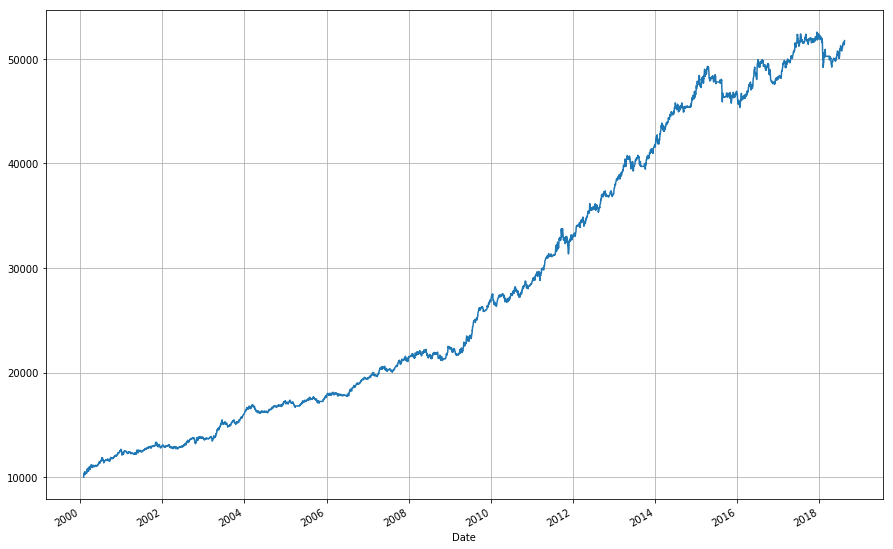

In [3]:
symbols =['VCVSX','VWINX','VWEHX','VGHCX','VUSTX','VFIIX','VWAHX','FGOVX','FFXSX']
cash_proxy = 'CASHX'
risk_free = 'FFXSX'

rs_lookback = 1
risk_lookback = 1
n_top = 3

# get data
tickers = symbols.copy()
if cash_proxy != 'CASHX' :
    tickers = list(set(tickers + [cash_proxy]))
if isinstance(risk_free, str) :
    tickers = list(set(tickers + [risk_free]))

# Define which online source one should use
data_source = 'yahoo'

# We would like all available data from 01/01/2000 until today.
start_date = '2000-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

# User pandas_reader.data.DataReader to load the desired data. As simple as that.
panel_data = web.DataReader(tickers, data_source, start_date, end_date)
data = panel_data['Adj Close'].sort_index(ascending=True)

inception_dates = pd.DataFrame([data[ticker].first_valid_index() for ticker in data.columns], 
                               index=data.keys(), columns=['inception'])

print (inception_dates)

prices = data.copy().dropna()

end_points = endpoints(period='M', trading_days=prices.index)
prices_m = prices.loc[end_points]

returns = prices_m[symbols].pct_change(rs_lookback)[rs_lookback:]
absolute_momentum_rule = returns > 0

if isinstance(risk_free, int) :
    excess_returns = returns
else :
    risk_free_returns =  prices_m[risk_free].pct_change(rs_lookback)[rs_lookback:]
    excess_returns = returns.subtract(risk_free_returns, axis=0).dropna()
    
rebalance_dates = excess_returns.index.join(absolute_momentum_rule.index, how='inner')

# relative strength ranking               
ranked = excess_returns.loc[rebalance_dates][symbols].rank(ascending=False, axis=1, method='dense')
# elligibility rule - top n_top ranked securities
elligible = ranked[ranked<=n_top] > 0

# equal weight allocations
elligible = elligible.multiply(1./elligible.sum(1), axis=0)

# downside protection
weights = pd.DataFrame(0.,index=elligible.index, columns=prices.columns)
if cash_proxy == 'CASHX' :
    weights[cash_proxy] = 0
    prices[cash_proxy] = 1.
weights[symbols] = (elligible * absolute_momentum_rule).dropna() 
weights[cash_proxy] += 1 - weights[symbols].sum(axis=1)

# backtest

p_value, p_holdings, p_weights = backtest(prices, weights, 10000., offset=0, commission=10.)

p_value.plot(figsize=(15,10), grid=True)

In [4]:
# algo stats
ffn.calc_perf_stats(p_value).display()

Stats for None from 2000-01-31 00:00:00 - 2018-08-14 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
414.77%             1.53  9.24%   -7.99%

Annualized Returns:
mtd    3m     6m     ytd     1y      3y     5y     10y    incep.
-----  -----  -----  ------  ------  -----  -----  -----  --------
0.41%  2.91%  2.77%  -1.71%  -0.27%  2.53%  4.90%  8.94%  9.24%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  1.53     1.63       1.38
mean    9.03%    9.00%      8.25%
vol     5.90%    5.51%      5.98%
skew    -0.20    0.24       0.19
kurt    2.90     0.14       -0.71
best    2.26%    5.58%      19.63%
worst   -2.23%   -3.07%     -1.71%

Drawdowns:
max     avg       # days
------  ------  --------
-7.99%  -0.97%     21.66

Misc:
---------------  ------
avg. up month    1.65%
avg. down month  -0.88%
up year %        94.44%
12m up %         92.96%
-

In [5]:
show_return_table(p_value)

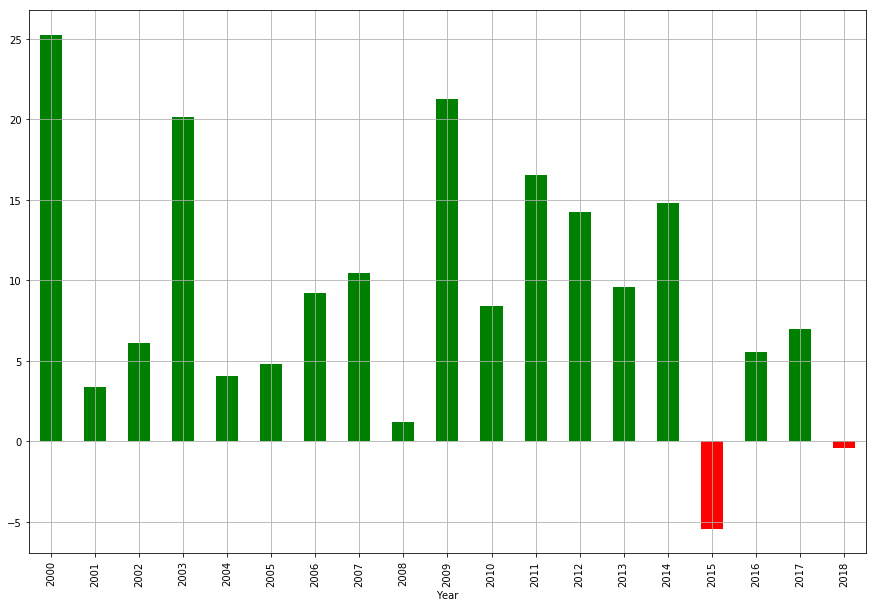

In [6]:
df = monthly_return_table (p_value)
frame = df['Annual Returns'].to_frame()
frame['positive'] = df['Annual Returns'] >= 0
frame['Annual Returns'].plot(figsize=(15,10),kind='bar',color=frame.positive.map({True: 'g', False: 'r'}), grid=True)

# DM0002

         inception
Symbols           
FFXSX   1999-12-31
FRESX   1999-12-31
VCVSX   1999-12-31
VFIIX   1999-12-31
VGHCX   1999-12-31
VUSTX   1999-12-31
VWEHX   1999-12-31
FIRST BUY DATE = 2000-01-31 00:00:00



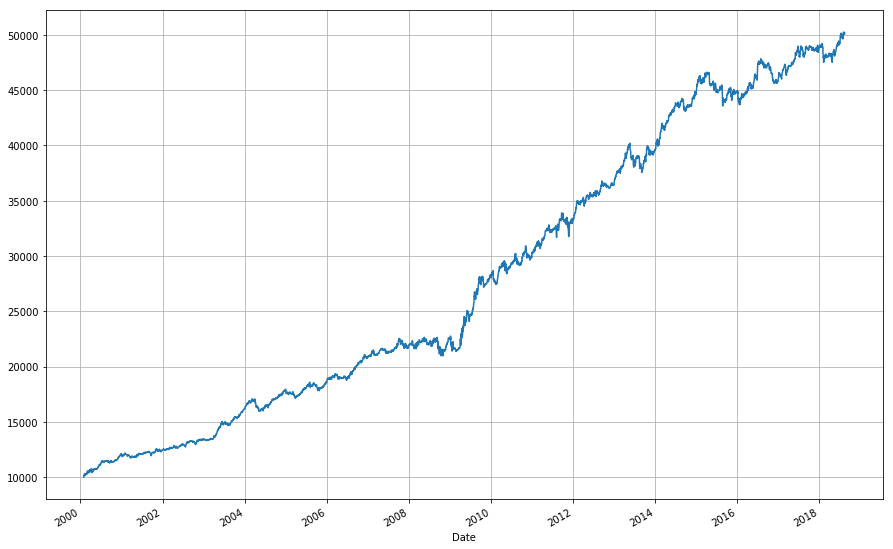

In [7]:
symbols =['VCVSX','VUSTX','VWEHX','VFIIX','VGHCX','FRESX']
cash_proxy = 'VFIIX'
risk_free = 'FFXSX'

rs_lookback = 1
risk_lookback = 1
n_top = 5

# get data
tickers = symbols.copy()
if cash_proxy != 'CASHX' :
    tickers = list(set(tickers + [cash_proxy]))
if isinstance(risk_free, str) :
    tickers = list(set(tickers + [risk_free]))

data = pd.DataFrame (columns=tickers)

# Define which online source one should use
data_source = 'yahoo'

# We would like all available data from 01/01/2000 until today.
start_date = '2000-01-01'
end_date = datetime.datetime.today().strftime('%Y-%m-%d')

# User pandas_reader.data.DataReader to load the desired data. As simple as that.
panel_data = web.DataReader(tickers, data_source, start_date, end_date)
data = panel_data['Adj Close'].sort_index(ascending=True)
         
inception_dates = pd.DataFrame([data[ticker].first_valid_index() for ticker in data.columns], 
                               index=data.keys(), columns=['inception'])

print (inception_dates)

prices = data.copy().dropna()

end_points = endpoints(period='M', trading_days=prices.index)
prices_m = prices.loc[end_points]

returns = prices_m[symbols].pct_change(rs_lookback)[rs_lookback:]
absolute_momentum_rule = returns > 0

if isinstance(risk_free, int) :
    excess_returns = returns
else :
    risk_free_returns =  prices_m[risk_free].pct_change(rs_lookback)[rs_lookback:]
    excess_returns = returns.subtract(risk_free_returns, axis=0).dropna()
    
rebalance_dates = excess_returns.index.join(absolute_momentum_rule.index, how='inner')

# relative strength ranking               
ranked = excess_returns.loc[rebalance_dates][symbols].rank(ascending=False, axis=1, method='dense')
# elligibility rule - top n_top ranked securities
elligible = ranked[ranked<=n_top] > 0

# equal weight allocations
elligible = elligible.multiply(1./elligible.sum(1), axis=0)

# downside protection
weights = pd.DataFrame(0.,index=elligible.index, columns=prices.columns)
if cash_proxy == 'CASHX' :
    weights[cash_proxy] = 0
    prices[cash_proxy] = 1.
weights[symbols] = (elligible * absolute_momentum_rule).dropna() 
weights[cash_proxy] += 1 - weights[symbols].sum(axis=1)

# backtest

p_value, p_holdings, p_weights = backtest(prices, weights, 10000., offset=0, commission=10.)

p_value.plot(figsize=(15,10), grid=True)

In [8]:
# algo stats
ffn.calc_perf_stats(p_value).display()

Stats for None from 2000-01-31 00:00:00 - 2018-08-14 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
401.73%             1.41  9.09%   -7.41%

Annualized Returns:
mtd    3m     6m     ytd    1y     3y     5y     10y    incep.
-----  -----  -----  -----  -----  -----  -----  -----  --------
0.33%  3.39%  4.94%  2.65%  3.81%  3.51%  5.32%  8.36%  9.09%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  1.41     1.54       1.33
mean    8.92%    8.87%      8.38%
vol     6.31%    5.75%      6.32%
skew    -0.29    0.27       1.21
kurt    8.36     2.95       1.40
best    3.27%    8.90%      24.31%
worst   -3.30%   -5.06%     0.69%

Drawdowns:
max     avg       # days
------  ------  --------
-7.41%  -0.90%     20.16

Misc:
---------------  -------
avg. up month    1.46%
avg. down month  -1.12%
up year %        100.00%
12m up %         94.84%
-------

In [9]:
show_return_table(p_value)

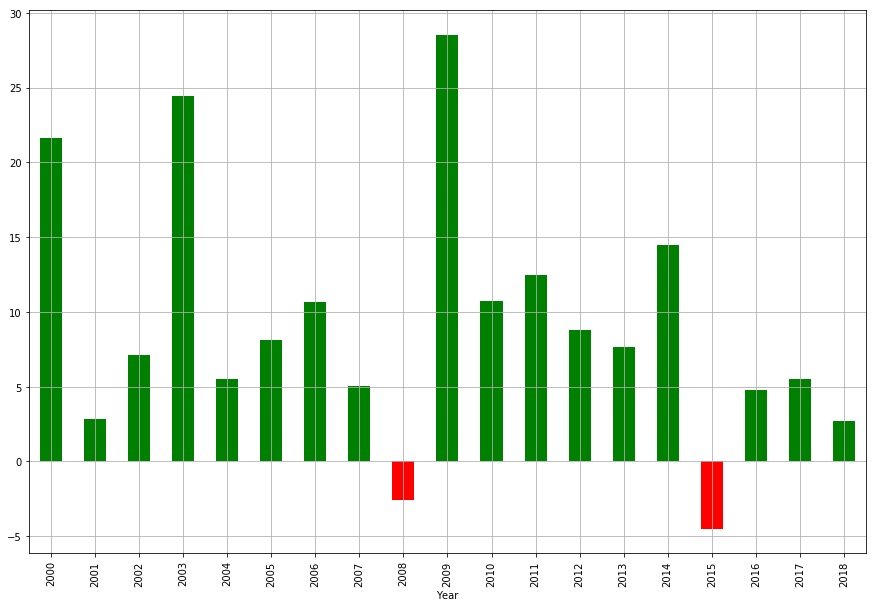

In [10]:
df = monthly_return_table (p_value)
frame = df['Annual Returns'].to_frame()
frame['positive'] = df['Annual Returns'] >= 0
frame['Annual Returns'].plot(figsize=(15,10),kind='bar',color=frame.positive.map({True: 'g', False: 'r'}), grid=True)

# STEP BY STEP BACKTEST

In [11]:
symbols =['VCVSX','VWINX','VWEHX','VGHCX','VFIIX','VWAHX','FGOVX','FFXSX']
cash_proxy = 'VUSTX'
risk_free = 0


# get data
tickers = symbols.copy()
if cash_proxy != 'CASHX' :
    tickers = list(set(tickers + [cash_proxy]))
if isinstance(risk_free, str) :
    tickers = list(set(tickers + [risk_free]))

data = pd.DataFrame (columns=tickers)
# Define which online source one should use
data_source = 'yahoo'

# We would like all available data from 01/01/2000 until today.
start_date = '1986-01-01'
end_date = datetime.datetime.today().strftime('%Y-%m-%d')

# User pandas_reader.data.DataReader to load the desired data. As simple as that.
panel_data = web.DataReader(tickers, data_source, start_date, end_date)
data = panel_data['Adj Close'].sort_index(ascending=True)
         
inception_dates = pd.DataFrame([data[ticker].first_valid_index() for ticker in data.columns], 
                               index=data.keys(), columns=['inception'])


In [12]:
inception_dates

,inception
Symbols,
FFXSX,1986-11-10
FGOVX,1985-12-31
VCVSX,1986-06-17
VFIIX,1985-12-31
VGHCX,1985-12-31
VUSTX,1986-05-19
VWAHX,1985-12-31
VWEHX,1985-12-31
VWINX,1985-12-31


In [13]:
data[:3]

Symbols,FFXSX,FGOVX,VCVSX,VFIIX,VGHCX,VUSTX,VWAHX,VWEHX,VWINX
Date,,,,,,,,,
1985-12-31,NaN,1.578820,NaN,1.438239,2.138680,NaN,1.503785,0.569066,1.682707
1986-01-02,NaN,1.577209,NaN,1.438239,2.147063,NaN,1.506793,0.569066,1.683805
1986-01-03,NaN,1.575598,NaN,1.436792,2.159635,NaN,1.509801,0.569066,1.683805


In [14]:
prices = data.copy().dropna()
prices[:5]

Symbols,FFXSX,FGOVX,VCVSX,VFIIX,VGHCX,VUSTX,VWAHX,VWEHX,VWINX
Date,,,,,,,,,
1986-11-10,2.308182,1.774089,1.167855,1.567637,2.634581,1.212652,1.704127,0.663242,1.967932
1986-11-11,2.308182,1.777567,1.167855,1.567637,2.631764,1.212652,1.704127,0.663242,1.969088
1986-11-12,2.308182,1.777567,1.166667,1.570789,2.623316,1.216269,1.707340,0.663951,1.971400
1986-11-13,2.308182,1.781047,1.167855,1.573940,2.600786,1.221091,1.710556,0.664662,1.967932
1986-11-14,2.308182,1.782785,1.166667,1.577092,2.603603,1.224707,1.712162,0.665372,1.973713


In [15]:
end_points = endpoints(period='M', trading_days=prices.index)
prices_m = prices.loc[end_points]

rs_lookback = 1
risk_lookback = 1
n_top = 3

In [16]:
print(symbols)

['VCVSX', 'VWINX', 'VWEHX', 'VGHCX', 'VFIIX', 'VWAHX', 'FGOVX', 'FFXSX']


In [17]:
returns = prices_m[symbols].pct_change(rs_lookback)[rs_lookback:]
absolute_momentum_rule = returns > 0
if isinstance(risk_free, int) :
    excess_returns = returns
else :
    risk_free_returns =  prices_m[risk_free].pct_change(rs_lookback)[rs_lookback:]
    excess_returns = returns.subtract(risk_free_returns, axis=0).dropna()
    
rebalance_dates = excess_returns.index.join(absolute_momentum_rule.index, how='inner')

In [18]:
returns[:3]

Symbols,VCVSX,VWINX,VWEHX,VGHCX,VFIIX,VWAHX,FGOVX,FFXSX
Date,,,,,,,,
1986-12-31,-0.003080,-0.032117,0.004210,-0.054663,0.005719,-0.002186,0.002659,0.002314
1987-01-30,0.048553,0.046098,0.023807,0.151928,0.013589,0.031438,0.009467,0.007579
1987-02-27,0.056158,0.001175,0.018741,0.011528,0.009352,0.004154,0.003434,0.003129


In [19]:
# relative strength ranking               
ranked = excess_returns.loc[rebalance_dates][symbols].rank(ascending=False, axis=1, method='dense')
# elligibility rule - top n_top ranked securities
elligible = ranked[ranked<=n_top] > 0
elligible[:3]

Symbols,VCVSX,VWINX,VWEHX,VGHCX,VFIIX,VWAHX,FGOVX,FFXSX
Date,,,,,,,,
1986-12-31,False,False,True,False,True,False,True,False
1987-01-30,True,True,False,True,False,False,False,False
1987-02-27,True,False,True,True,False,False,False,False


In [20]:
# equal weight allocations
elligible = elligible.multiply(1./elligible.sum(1), axis=0)
elligible[:3]

Symbols,VCVSX,VWINX,VWEHX,VGHCX,VFIIX,VWAHX,FGOVX,FFXSX
Date,,,,,,,,
1986-12-31,0.000000,0.000000,0.333333,0.000000,0.333333,0.0,0.333333,0.0
1987-01-30,0.333333,0.333333,0.000000,0.333333,0.000000,0.0,0.000000,0.0
1987-02-27,0.333333,0.000000,0.333333,0.333333,0.000000,0.0,0.000000,0.0


In [21]:
prices.columns

Index(['FFXSX', 'FGOVX', 'VCVSX', 'VFIIX', 'VGHCX', 'VUSTX', 'VWAHX', 'VWEHX',
       'VWINX'],
      dtype='object', name='Symbols')

In [22]:
cash_proxy

'VUSTX'

In [23]:
# downside protection
weights = pd.DataFrame(0.,index=elligible.index, columns=prices.columns)
if cash_proxy == 'CASHX' :
    weights[cash_proxy] = 0
    prices[cash_proxy] = 1.
weights[symbols] = (elligible * absolute_momentum_rule).dropna() 
weights[:10]

Symbols,FFXSX,FGOVX,VCVSX,VFIIX,VGHCX,VUSTX,VWAHX,VWEHX,VWINX
Date,,,,,,,,,
1986-12-31,0.000000,0.333333,0.000000,0.333333,0.000000,0.0,0.000000,0.333333,0.000000
1987-01-30,0.000000,0.000000,0.333333,0.000000,0.333333,0.0,0.000000,0.000000,0.333333
1987-02-27,0.000000,0.000000,0.333333,0.000000,0.333333,0.0,0.000000,0.333333,0.000000
1987-03-31,0.333333,0.000000,0.000000,0.000000,0.333333,0.0,0.000000,0.333333,0.000000
1987-04-30,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
1987-05-29,0.333333,0.000000,0.000000,0.000000,0.333333,0.0,0.000000,0.000000,0.000000
1987-06-30,0.000000,0.000000,0.000000,0.000000,0.333333,0.0,0.333333,0.000000,0.333333
1987-07-31,0.000000,0.000000,0.333333,0.000000,0.333333,0.0,0.333333,0.000000,0.000000
1987-08-31,0.000000,0.000000,0.333333,0.000000,0.000000,0.0,0.000000,0.333333,0.333333


In [24]:
weights[cash_proxy] += 1 - weights[symbols].sum(axis=1)
weights[:10]

Symbols,FFXSX,FGOVX,VCVSX,VFIIX,VGHCX,VUSTX,VWAHX,VWEHX,VWINX
Date,,,,,,,,,
1986-12-31,0.000000,0.333333,0.000000,0.333333,0.000000,0.000000,0.000000,0.333333,0.000000
1987-01-30,0.000000,0.000000,0.333333,0.000000,0.333333,0.000000,0.000000,0.000000,0.333333
1987-02-27,0.000000,0.000000,0.333333,0.000000,0.333333,0.000000,0.000000,0.333333,0.000000
1987-03-31,0.333333,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.333333,0.000000
1987-04-30,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
1987-05-29,0.333333,0.000000,0.000000,0.000000,0.333333,0.333333,0.000000,0.000000,0.000000
1987-06-30,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.333333,0.000000,0.333333
1987-07-31,0.000000,0.000000,0.333333,0.000000,0.333333,0.000000,0.333333,0.000000,0.000000
1987-08-31,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.333333,0.333333


In [25]:
date = rebalance_dates[0]
weights.loc[date]

Symbols
FFXSX    0.000000
FGOVX    0.333333
VCVSX    0.000000
VFIIX    0.333333
VGHCX    0.000000
VUSTX    0.000000
VWAHX    0.000000
VWEHX    0.333333
VWINX    0.000000
Name: 1986-12-31 00:00:00, dtype: float64

In [26]:
prices.loc[date]

Symbols
FFXSX    2.324906
FGOVX    1.811328
VCVSX    1.159524
VFIIX    1.607926
VGHCX    2.483912
VUSTX    1.251566
VWAHX    1.736557
VWEHX    0.665885
VWINX    1.937181
Name: 1986-12-31 00:00:00, dtype: float64

In [27]:
(10000 * weights.loc[date] / prices.loc[date]).astype(int)

Symbols
FFXSX       0
FGOVX    1840
VCVSX       0
VFIIX    2073
VGHCX       0
VUSTX       0
VWAHX       0
VWEHX    5005
VWINX       0
Name: 1986-12-31 00:00:00, dtype: int64

FIRST BUY DATE = 1986-12-31 00:00:00



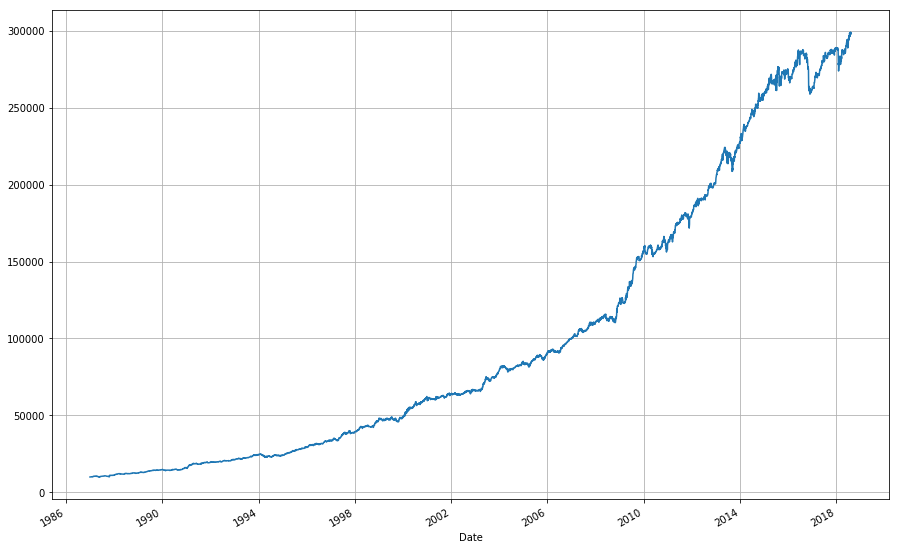

In [28]:
# backtest

p_value, p_holdings, p_weights = backtest(prices, weights, 10000., offset=0, commission=10.)

p_value.plot(figsize=(15,10), grid=True)

# SCRATCHPAD